In [1]:
import os
import warnings
import itertools
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm
from statsmodels.tsa import stattools
from statsmodels.tools.sm_exceptions import ConvergenceWarning

os.chdir('../../data')
data = pd.read_csv('data_whole.csv').transpose()
data_gdp = pd.read_csv('../data/gdp_per_worker_worldbank.csv', index_col=0)

#カラム設定
data.columns = data.iloc[2,:]

#不要列削除、被説明変数データ結合
data.drop(['Unnamed: 0', 'Indicator Name'], axis=0, inplace=True)
data = pd.concat([data_gdp, data], axis=1)

new_index = [i if i == 'Country Name' else int(i) for i in data.index]
data.index = new_index

#欠損値部分削除(1991~2020年データに整形)
data = data.iloc[:-2]


var_list = [

#被説明変数
'productivity_swe',
'productivity_fin',
'productivity_jap',
#経済
'Trade (% of GDP)', #国の経済の開放度を示す指標。0
'Total reserves minus gold (current US$)', #国の経済的安定性を示す指標。0
'Real effective exchange rate index (2010 = 100)', #実質実効為替レート。国の競争力を示す指標。
'Self-employed, total (% of total employment) (modeled ILO estimate)',
'Unemployment, total (% of total labor force)',
#医療
'Ratio of female to male labor force participation rate (%) (modeled ILO estimate)', #男女の労働参加率の比率。健康状態や社会的要因が労働参加に与える影響を示す
'Life expectancy at birth, total (years)', #出生時の平均余命。国の医療システムの質や健康状態を示す。
'Probability of dying among youth ages 20-24 years (per 1,000)', #20-24歳の死亡率。若年労働者の健康状態やリスクを示す。
'Number of under-five deaths', # 5歳未満の死亡数は、公衆衛生や医療の質を示す指標として考えられます。
#教育
'Government expenditure on education as % of GDP (%)', #政府の教育投資割合
'Government expenditure on tertiary education, PPP$ (millions)',#tertiary educationへの政府の投資割合
#デモグラフィー
'Population growth (annual %)', #人口増加率
'Urban population (% of total population)', #都市部人口比率
'Population density (people per sq. km of land area)' #人口密度

]

data = data[var_list].transpose()

#sweden
df_swe = data[data['Country Name'] == 'Sweden'].transpose()
df_swe = df_swe.drop(['Country Name'], axis=0).astype(float)
df_swe.index = pd.date_range(start='1991-01-01', periods=len(df_swe), freq='Y')
df_swe = df_swe.loc[:, ~df_swe.columns.duplicated()]

#finland
df_fin = data[data['Country Name'] == 'Finland'].transpose()
df_fin = df_fin.drop(['Country Name'], axis=0).astype(float)
df_fin.index = pd.date_range(start='1991-01-01', periods=len(df_fin), freq='Y')
df_fin = df_fin.loc[:, ~df_fin.columns.duplicated()]

#japan
df_jap = data[data['Country Name'] == 'Japan'].transpose()
df_jap = df_jap.drop(['Country Name'], axis=0).astype(float)
df_jap.index = pd.date_range(start='1991-01-01', periods=len(df_jap), freq='Y')
df_jap = df_jap.loc[:, ~df_jap.columns.duplicated()]

df_dict = {'sweden': df_swe, 'finland': df_fin, 'japan': df_jap}

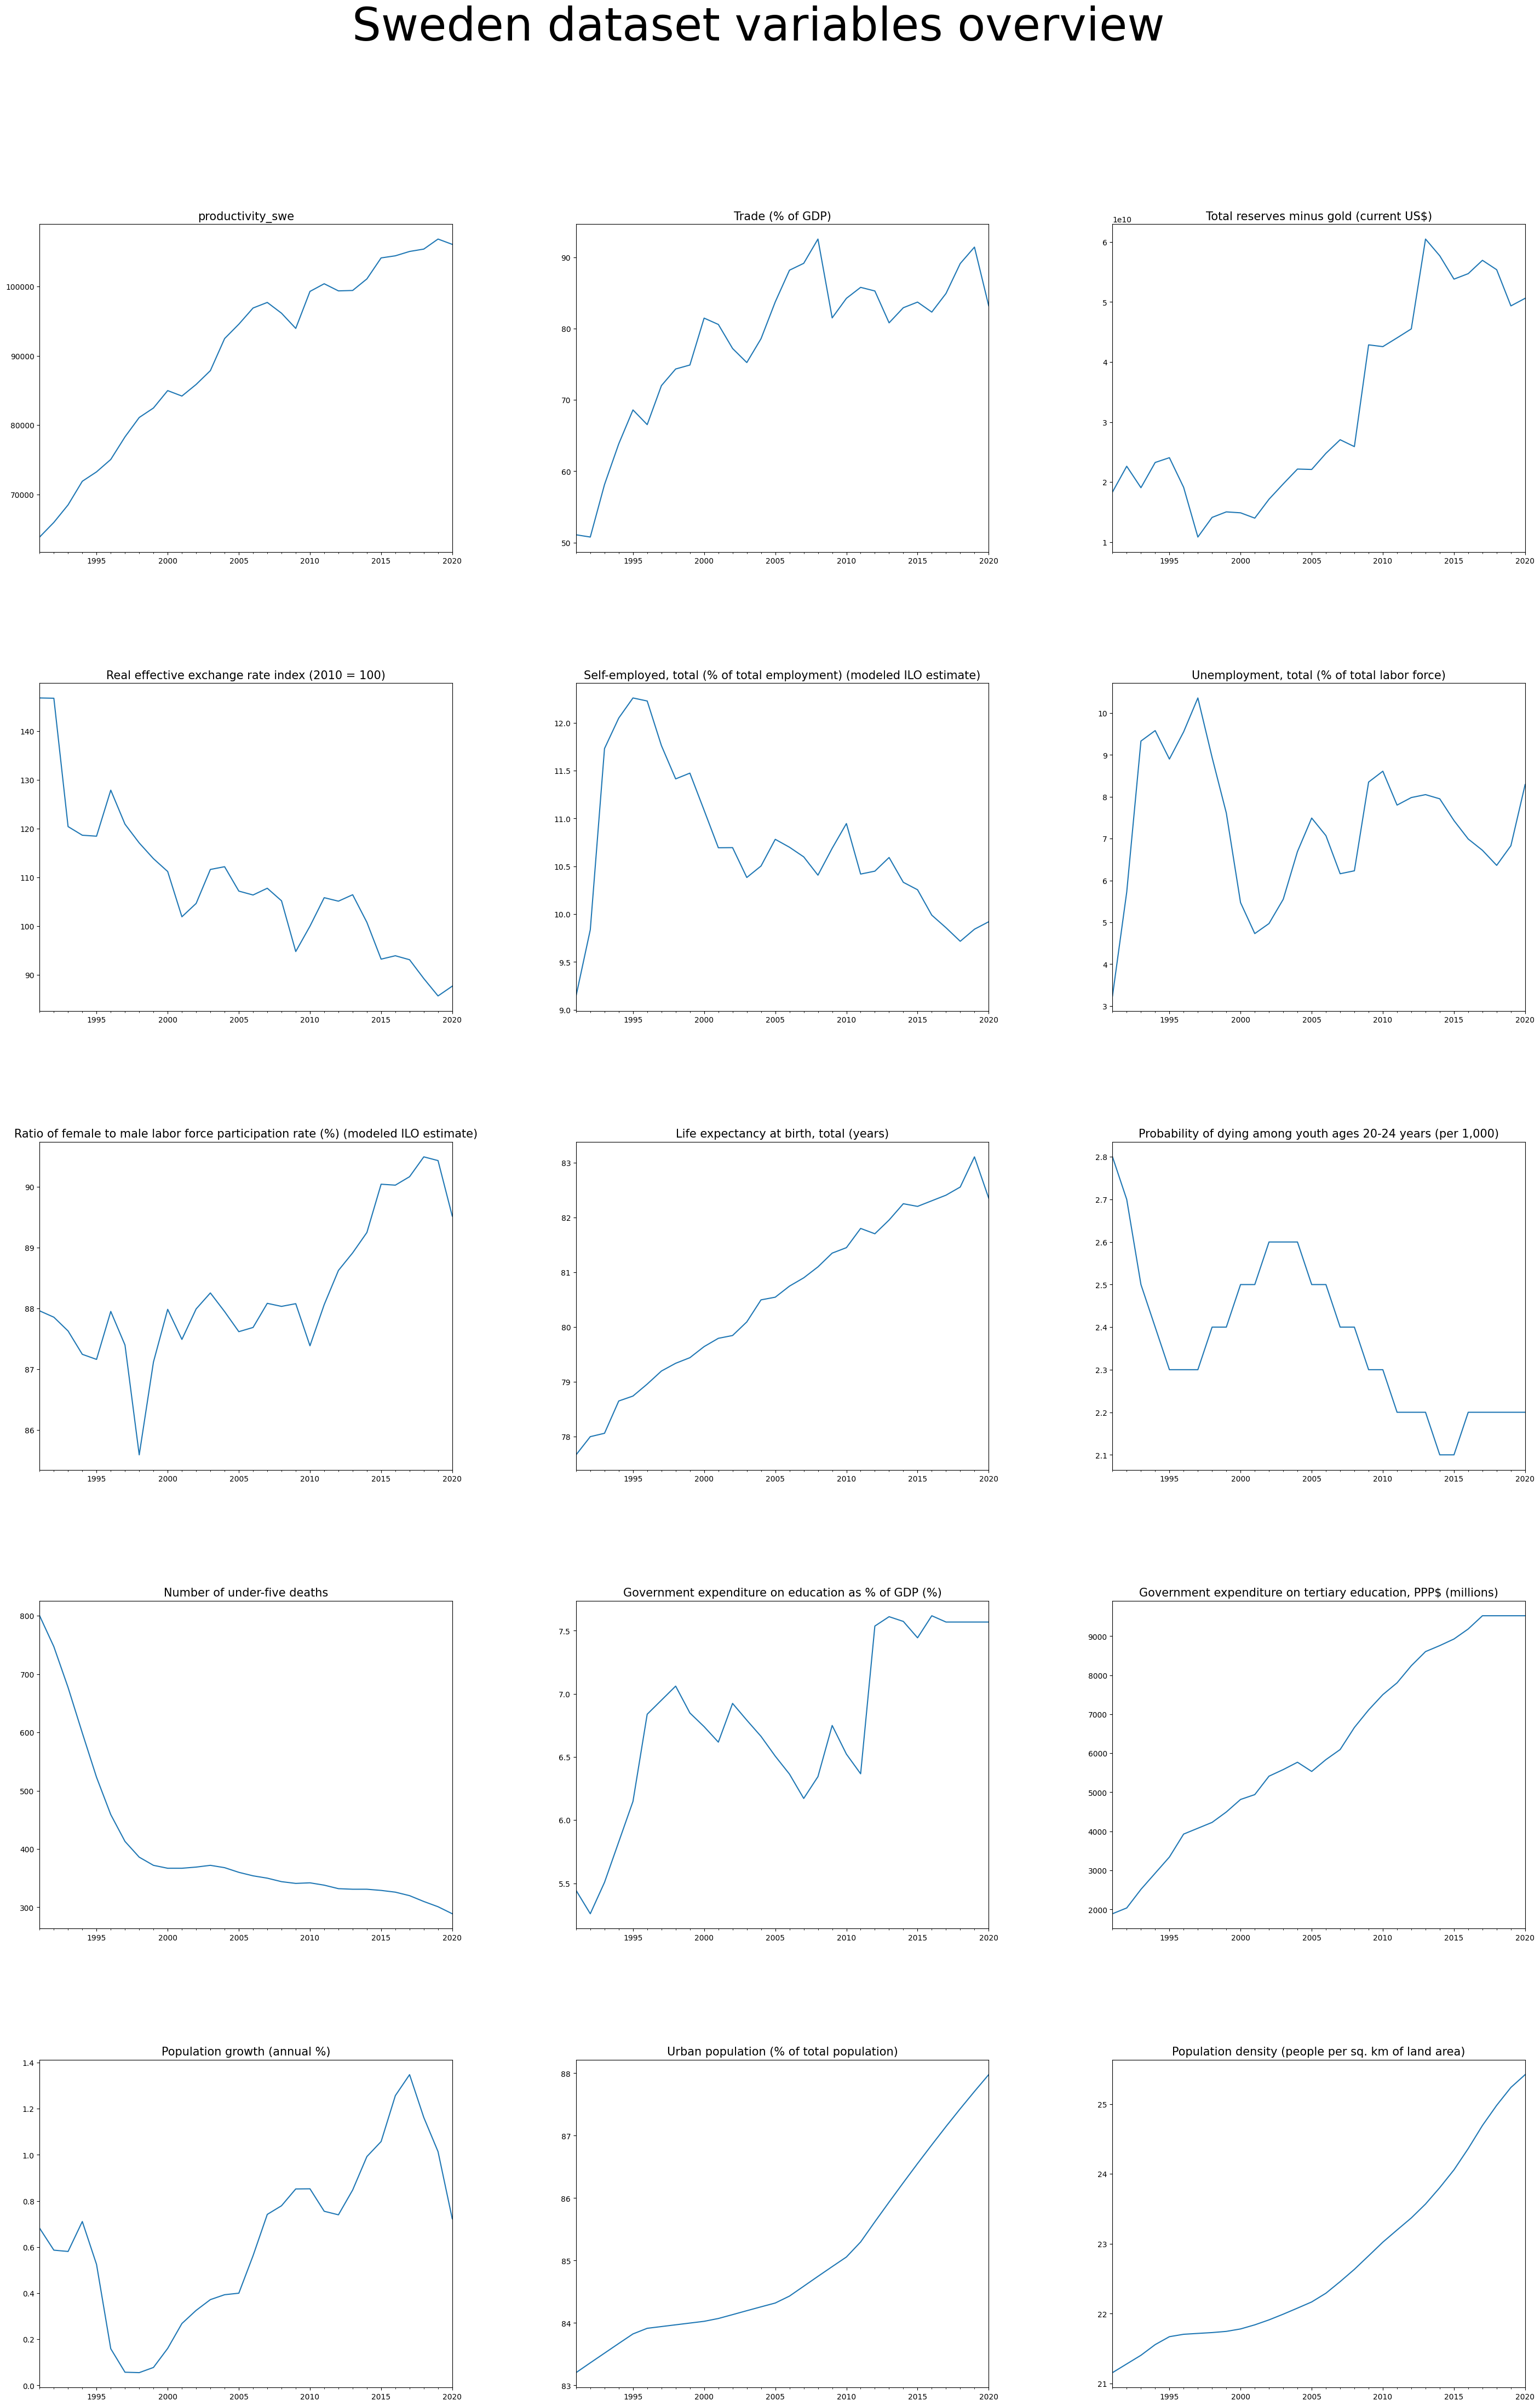

In [2]:
#sweden

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 描画の設定
n_rows, n_cols = 5, 3  # グラフを並べる行数と列数
fig, axes = plt.subplots(n_rows, n_cols, figsize=(35, 50))  # サイズは適宜調整してください。
fig.suptitle('Sweden dataset variables overview', fontsize=60)

# 各変数についてグラフを描画します。
for i, column in enumerate(df_swe.columns):
    ax = axes[i // n_cols, i % n_cols]
    df_swe[column].plot(ax=ax)
    ax.set_title(column, fontsize=15)

# 必要であれば、余分なサブプロットを非表示にします。
for i in range(n_rows * n_cols):
    if i >= len(df_swe.columns):
        axes.flatten()[i].axis('off')

# タイトルの重複を避けるために余白を調整します。
plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)

# 表示して確認します（必要であれば）。
plt.show()

In [ ]:
#finland

# 描画の設定
n_rows, n_cols = 5,3  # グラフを並べる行数と列数
fig, axes = plt.subplots(n_rows, n_cols, figsize=(35,50))  # サイズは適宜調整してください。
fig.suptitle('Finland dataset variables overview', fontsize=60)

# 各変数についてグラフを描画します。
for i, column in enumerate(df_fin.columns):
    ax = axes[i // n_cols, i % n_cols]
    df_fin[column].plot(ax=ax)
    ax.set_title(column, fontsize=14)

# 必要であれば、余分なサブプロットを非表示にします。
for i in range(n_rows * n_cols):
    if i >= len(df_fin.columns):
        axes.flatten()[i].axis('off')

# タイトルの重複を避けるために余白を調整します。
plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)

# 表示して確認します（必要であれば）。
plt.show()

In [ ]:
#japan

# 描画の設定
n_rows, n_cols = 5,3  # グラフを並べる行数と列数
fig, axes = plt.subplots(n_rows, n_cols, figsize=(35, 50))  # サイズは適宜調整してください。
fig.suptitle('Japan dataset variables overview', fontsize=60)

# 各変数についてグラフを描画します。
for i, column in enumerate(df_jap.columns):
    ax = axes[i // n_cols, i % n_cols]
    df_jap[column].plot(ax=ax)
    ax.set_title(column, fontsize=16)

# 必要であれば、余分なサブプロットを非表示にします。
for i in range(n_rows * n_cols):
    if i >= len(df_jap.columns):
        axes.flatten()[i].axis('off')

# タイトルの重複を避けるために余白を調整します。
plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)

# 表示して確認します（必要であれば）。
plt.show()

In [2]:

import matplotlib.pyplot as plt
from pandas.plotting import table

for key, df in df_dict.items():
    describe = df.describe()
    describe.to_csv(f'{key}_stats.csv')

In [ ]:
def plot_combined_table_with_index(df_dict, figsize=(14, 6), fontsize=8):
    for key, df in df_dict.items():
        # 説明統計量を取得し、転置
        describe = df.describe().T

        # 数値を小数第4位で切り捨て
        describe_rounded = describe.round(4)

        # インデックスをリセットして連番にする
        describe_rounded.reset_index(inplace=True)
        describe_rounded.index = describe_rounded.index + 1  # インデックスを1から開始する
        describe_rounded.drop('index', axis=1, inplace=True)

        # 出力する画像のサイズを設定
        fig, ax = plt.subplots(figsize=figsize)

        # テーブルを描画
        tbl = table(ax, describe_rounded, loc='upper center', fontsize=fontsize)
        tbl.auto_set_font_size(False)
        tbl.set_fontsize(fontsize)

        # 軸を非表示にする
        ax.axis('off')

        # タイトルを設定
        plt.title(f'Descriptive Statistics of {key} Dataset', fontsize=fontsize+2, weight='bold')

        # 画像を表示する
        plt.show()

# 修正した関数をデモデータでテスト
plot_combined_table_with_index(df_dict)


#### ADF検定
#すべての変数に対する検定。ARもMAも定常過程にしか適応できない。帰無仮説：単位根がある（非定常）
対立仮説：定数項＋定常過程

In [3]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# 空の DataFrame の作成
results_df = pd.DataFrame(columns=['Country', 'Variable', 'Status'])

for country, df in df_dict.items():
    for column in df.columns:
        y = df[column]

        # ADF検定の実行
        adf_result = adfuller(y, regression='c')
        p_value = adf_result[1]

        # 非定常性のチェック
        status = '*' if p_value >= 0.05 else ''

        # 新しい行を作成して DataFrame に追加
        new_row = pd.DataFrame({'Country': [country], 'Variable': [column], 'Status': [status]})
        results_df = pd.concat([results_df, new_row], ignore_index=True)

# 結果の表示
print(results_df)


    Country                                           Variable Status
0    sweden                                   productivity_swe      *
1    sweden                                   Trade (% of GDP)      *
2    sweden            Total reserves minus gold (current US$)      *
3    sweden    Real effective exchange rate index (2010 = 100)      *
4    sweden  Self-employed, total (% of total employment) (...      *
5    sweden       Unemployment, total (% of total labor force)       
6    sweden  Ratio of female to male labor force participat...      *
7    sweden            Life expectancy at birth, total (years)       
8    sweden  Probability of dying among youth ages 20-24 ye...      *
9    sweden                        Number of under-five deaths      *
10   sweden  Government expenditure on education as % of GD...      *
11   sweden  Government expenditure on tertiary education, ...      *
12   sweden                       Population growth (annual %)      *
13   sweden         

In [7]:
#1次階差データ
df_swe_diff = df_swe.diff().iloc[1:]
df_fin_diff = df_fin.diff().iloc[1:]
df_jap_diff = df_jap.diff().iloc[1:]

df_diff_dict = {'sweden':df_swe_diff, 'finland':df_fin_diff, 'japan':df_jap_diff}

In [8]:
#ADF検定(1次階差ver)
results_df = pd.DataFrame(columns=['Country', 'Variable', 'Status'])

for country, df in df_diff_dict.items():
    for column in df.columns:
        y = df[column]

        # ADF検定の実行
        adf_result = adfuller(y, regression='c')
        p_value = adf_result[1]

        # 非定常性のチェック
        status = '*' if p_value >= 0.05 else ''

        # 新しい行を作成して DataFrame に追加
        new_row = pd.DataFrame({'Country': [country], 'Variable': [column], 'Status': [status]})
        results_df = pd.concat([results_df, new_row], ignore_index=True)

# 結果の表示
print(results_df)

    Country                                           Variable Status
0    sweden                                   productivity_swe       
1    sweden                                   Trade (% of GDP)       
2    sweden            Total reserves minus gold (current US$)       
3    sweden    Real effective exchange rate index (2010 = 100)       
4    sweden  Self-employed, total (% of total employment) (...       
5    sweden       Unemployment, total (% of total labor force)       
6    sweden  Ratio of female to male labor force participat...       
7    sweden            Life expectancy at birth, total (years)       
8    sweden  Probability of dying among youth ages 20-24 ye...       
9    sweden                        Number of under-five deaths       
10   sweden  Government expenditure on education as % of GD...       
11   sweden  Government expenditure on tertiary education, ...      *
12   sweden                       Population growth (annual %)      *
13   sweden         

1次の階差を取り、大体の変数は時間に依存したランダム性を持つ単位根過程を脱し、定常であることが認められた。

#### 説明変数間の多重共線性確認
→相関係数を用いる

In [ ]:
#相関係数ヒートマップ

for country, df in df_dict.items():
    plt.figure(figsize=(20,15))# 新しいフィギュアを作成
    df_corr = df.corr()
    sns.heatmap(df_corr, annot=True)
    plt.title(country, fontsize=50)
    plt.show()  # ヒートマップを表示

In [ ]:
#相関係数ヒートマップ(diff)

for country, df in df_diff_dict.items():
    plt.figure(figsize=(20,15))# 新しいフィギュアを作成
    df_corr = df.corr()
    sns.heatmap(df_corr, annot=True)
    plt.title(country, fontsize=50)
    plt.show()  # ヒートマップを表示

### 時系列モデル構築

In [4]:
# 説明変数のリスト

independent_variables = [

#経済
'Trade (% of GDP)', #国の経済の開放度を示す指標。0
'Total reserves minus gold (current US$)', #国の経済的安定性を示す指標。0
'Real effective exchange rate index (2010 = 100)', #実質実効為替レート。国の競争力を示す指標。
'Self-employed, total (% of total employment) (modeled ILO estimate)',
'Unemployment, total (% of total labor force)',
#医療
'Ratio of female to male labor force participation rate (%) (modeled ILO estimate)', #男女の労働参加率の比率。健康状態や社会的要因が労働参加に与える影響を示す
'Life expectancy at birth, total (years)', #出生時の平均余命。国の医療システムの質や健康状態を示す。
'Probability of dying among youth ages 20-24 years (per 1,000)', #20-24歳の死亡率。若年労働者の健康状態やリスクを示す。
'Number of under-five deaths', # 5歳未満の死亡数は、公衆衛生や医療の質を示す指標として考えられます。
#教育
'Government expenditure on education as % of GDP (%)', #政府の教育投資割合
'Government expenditure on tertiary education, PPP$ (millions)',#tertiary educationへの政府の投資割合
#デモグラフィー
'Population growth (annual %)', #人口増加率
'Urban population (% of total population)', #都市部人口比率
'Population density (people per sq. km of land area)' #人口密度

]

# 組み合わせのリストを生成します
combinations_of_variables = []
for r in range(1, len(independent_variables) + 1):
    combinations_of_variables.extend(
        itertools.combinations(independent_variables, r)
    )
    
print(f'組み合わせ総数: {len(combinations_of_variables)}')

組み合わせ総数: 16383


In [5]:
country_models = []

for country, df in df_dict.items():

    # 警告を非表示にする
    warnings.filterwarnings("ignore")

    # 各国の最良モデル情報を格納する変数の初期化
    best_aic = float('inf')
    best_model_info = None

    # 進捗の可視化
    for combination in tqdm(combinations_of_variables, 
                            total=len(combinations_of_variables), 
                            desc=f"Fitting Models for {country}"):
        
        # 説明変数
        X = df[list(combination)]
        
        # 被説明変数
        y = df.iloc[:,0] 
        
        # 状態空間モデルフィット
        model = sm.tsa.UnobservedComponents(y, 'lltrend', exog=X)
        
        try:
            results = model.fit()
            # AICで最良のモデルを更新
            if results.aic < best_aic:
                best_aic = results.aic
                best_model_info = {
                    'country': country,
                    'variables': combination,
                    'AIC': results.aic,
                    'BIC': results.bic,
                    'LLF': results.llf
                }
        except ValueError as e:
            continue

    # 警告表示を元に戻す
    warnings.filterwarnings("default")

    # 最良モデルが見つかった場合、結果をcountry_modelsに追加
    if best_model_info:
        country_models.append(best_model_info)

# すべての国の最良モデルの結果をデータフレームに変換
country_models_df = pd.DataFrame(country_models)

#変数選択結果をcsvに出力
country_models_df.to_csv('../models/ssm/bast_models.csv')

Fitting Models for finland:   2%|▏         | 303/16383 [00:39<34:50,  7.69it/s]  


KeyboardInterrupt: 

In [ ]:
country_models = []

for country, df in df_dict.items():

    # 警告を非表示にする
    warnings.filterwarnings("ignore")

    # 各国の最良モデル情報を格納する変数の初期化
    best_aic = float('inf')
    best_model_info = None

    # 進捗の可視化
    for combination in tqdm(combinations_of_variables, total=len(combinations_of_variables), desc=f"Fitting Models for {country}"):
        # 説明変数
        X = df[list(combination)]
        
        # 被説明変数
        y = df.iloc[:,0] 
        
        # 状態空間モデルフィット
        model = sm.tsa.UnobservedComponents(y, 'llevel', exog=X)
        
        try:
            results = model.fit()
            # AICで最良のモデルを更新
            if results.aic < best_aic:
                best_aic = results.aic
                best_model_info = {
                    'country': country,
                    'variables': combination,
                    'AIC': results.aic,
                    'BIC': results.bic,
                    'LLF': results.llf
                }
        except ValueError as e:
            # 収束しなかった場合の処理はここでは省略
            continue

    # 警告表示を元に戻す
    warnings.filterwarnings("default")

    # 最良モデルが見つかった場合、結果をcountry_modelsに追加
    if best_model_info:
        country_models.append(best_model_info)

# すべての国の最良モデルの結果をデータフレームに変換
country_models_df = pd.DataFrame(country_models)

#csvに出力
country_models_df.to_csv('../models/ssm/bast_models.csv')

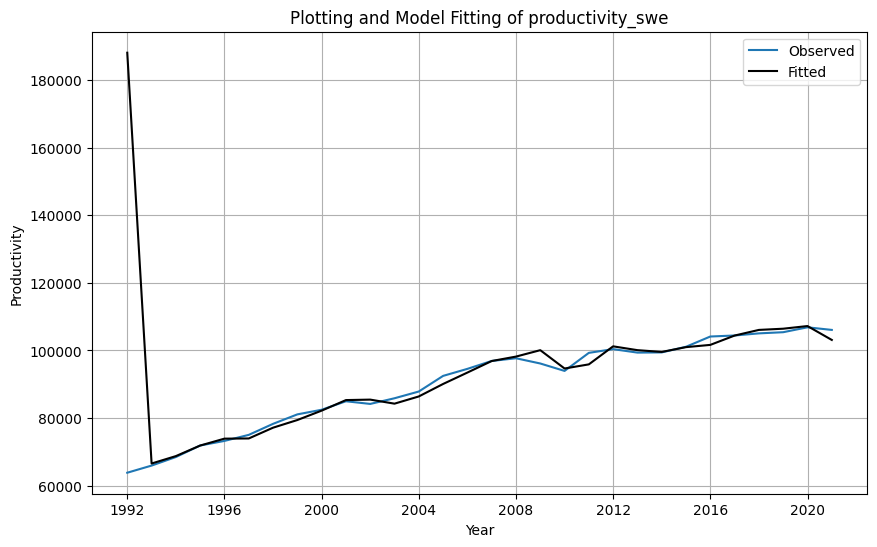

                        Unobserved Components Results                         
Dep. Variable:       productivity_swe   No. Observations:                   30
Model:                    local level   Log Likelihood                -253.584
Date:                Wed, 13 Dec 2023   AIC                            519.169
Time:                        13:33:25   BIC                            527.373
Sample:                    12-31-1991   HQIC                           521.738
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                                                                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
sigma2.irregular                                                    1.293e+04   2.97e+04      0.43

In [6]:
#sweden

dep = df_swe.iloc[:,0]
exogs = ['Trade (% of GDP)',
         'Life expectancy at birth, total (years)',
         'Government expenditure on education as % of GDP (%)',
         'Government expenditure on tertiary education, PPP$ (millions)']

bestmodel_swe = sm.tsa.UnobservedComponents(dep, 'llevel', exog = df_swe[exogs])
results_swe = bestmodel_swe.fit()

 # 元のデータとモデルによる予測値をプロット
plt.figure(figsize=(10, 6)) # グラフのサイズを設定
plt.plot(df_swe.index, df_swe['productivity_swe'], label='Observed')  # 元のデータをプロット
plt.plot(df_swe.index, results_swe.fittedvalues, label='Fitted', color='k')  # フィットした値をプロット

# グラフのタイトルと軸ラベルを設定
plt.title(f'Plotting and Model Fitting of productivity_swe')
plt.xlabel('Year')
plt.ylabel('Productivity')

# 凡例を表示
plt.legend()

# グリッドを表示
plt.grid(True)

# グラフを表示
plt.show()

#results
print(results_swe.summary())

tables = results_swe.summary().tables
params_df = pd.DataFrame(tables[1].data[1:], columns=tables[1].data[0])

In [ ]:
from PIL import Image, ImageDraw, ImageFont

# 結果のサマリーを取得
summary_text = results_swe.summary().as_text()

# 画像としてサマリーを保存
def text_to_image(text, file_name):
    # テキストを挿入するための画像を作成
    # 背景は白で、サイズは適切に調整してください
    image = Image.new('RGB', (850, 450), color = (255, 255, 255))
    d = ImageDraw.Draw(image)
    
    # フォントの設定（適切なパスとサイズに調整してください）
    font = ImageFont.load_default()
    
    # テキストを画像上に配置
    d.text((10,10), text, fill=(0,0,0), font=font)
    
    # 画像をファイルに保存
    image.save(file_name)

# 画像として出力
text_to_image(summary_text, '../models/model_summary_swe.png')

In [ ]:
#finland

dep = df_fin.iloc[:,0]
exogs = ['Trade (% of GDP)',
         'Self-employed, total (% of total employment) (modeled ILO estimate)',
         'Unemployment, total (% of total labor force)',
         'Number of under-five deaths',
         'Government expenditure on education as % of GDP (%)']

bestmodel_fin = sm.tsa.UnobservedComponents(dep, 'llevel', exog = df_fin[exogs])
results_fin = bestmodel_fin.fit()

 # 元のデータとモデルによる予測値をプロット
plt.figure(figsize=(10, 6)) # グラフのサイズを設定
plt.plot(df_fin.index, df_fin.iloc[:,0], label='Observed')  # 元のデータをプロット
plt.plot(df_fin.index, results_swe.fittedvalues, label='Fitted', color='k')  # フィットした値をプロット

# グラフのタイトルと軸ラベルを設定
plt.title(f'Plotting and Model Fitting of productivity_fin')
plt.xlabel('Year')
plt.ylabel('Productivity')

# 凡例を表示
plt.legend()

# グリッドを表示
plt.grid(True)

# グラフを表示
plt.show()

#results
print(results_fin.summary())

tables = results_fin.summary().tables
params_df = pd.DataFrame(tables[1].data[1:], columns=tables[1].data[0])

# CSVファイルに出力
params_df.to_csv('../models/model_parameters_fin.csv', index=False)

In [ ]:
from PIL import Image, ImageDraw, ImageFont

# 結果のサマリーを取得
summary_text = results_fin.summary().as_text()

# 画像としてサマリーを保存
def text_to_image(text, file_name):
    # テキストを挿入するための画像を作成
    # 背景は白で、サイズは適切に調整してください
    image = Image.new('RGB', (850, 450), color = (255, 255, 255))
    d = ImageDraw.Draw(image)
    
    # フォントの設定（適切なパスとサイズに調整してください）
    font = ImageFont.load_default()
    
    # テキストを画像上に配置
    d.text((10,10), text, fill=(0,0,0), font=font)
    
    # 画像をファイルに保存
    image.save(file_name)

# 画像として出力
text_to_image(summary_text, '../models/model_summary_fin.png')

In [ ]:
#japan

dep = df_jap.iloc[:,0]
exogs = ['Trade (% of GDP)',
         'Probability of dying among youth ages 20-24 years (per 1,000)',
         'Population density (people per sq. km of land area)']

bestmodel_jap = sm.tsa.UnobservedComponents(dep, 'llevel', exog = df_jap[exogs])
results_jap = bestmodel_jap.fit()

 # 元のデータとモデルによる予測値をプロット
plt.figure(figsize=(10, 6)) # グラフのサイズを設定
plt.plot(df_jap.index, df_jap['productivity_jap'], label='Observed')  # 元のデータをプロット
plt.plot(df_jap.index, results_jap.fittedvalues, label='Fitted', color='k')  # フィットした値をプロット

# グラフのタイトルと軸ラベルを設定
plt.title(f'Plotting and Model Fitting of productivity_jap')
plt.xlabel('Year')
plt.ylabel('Productivity')

# 凡例を表示
plt.legend()

# グリッドを表示
plt.grid(True)

# グラフを表示
plt.show()

#results
print(results_jap.summary())

tables = results_jap.summary().tables
params_df = pd.DataFrame(tables[1].data[1:], columns=tables[1].data[0])

# CSVファイルに出力
params_df.to_csv('../models/model_parameters_jap.csv', index=False)

In [ ]:
from PIL import Image, ImageDraw, ImageFont

# 結果のサマリーを取得
summary_text = results_jap.summary().as_text()

# 画像としてサマリーを保存
def text_to_image(text, file_name):
    # テキストを挿入するための画像を作成
    # 背景は白で、サイズは適切に調整してください
    image = Image.new('RGB', (850, 450), color = (255, 255, 255))
    d = ImageDraw.Draw(image)
    
    # フォントの設定（適切なパスとサイズに調整してください）
    font = ImageFont.load_default()
    
    # テキストを画像上に配置
    d.text((10,10), text, fill=(0,0,0), font=font)
    
    # 画像をファイルに保存
    image.save(file_name)

# 画像として出力
text_to_image(summary_text, '../models/model_summary_jap.png')